## Importing libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import cufflinks as cf
import folium
import statsmodels.api as sm
from pylab import rcParams
import numpy as np

In [23]:
def create_catplot(data, x, y, kind, col=None, sharey=True):
    """
    Input: data --> DataFrame
           x --> String 
           y --> String
           kind --> String
           col --> String
           sharey --> Boolean
    Output: FacetGrid (bar plots)
    
    
    """
    
    return sns.catplot(x=x, y=y, col=col, data=data, col_wrap=4, kind='bar', sharey=False)

In [32]:
def set_xticklabels(fg, rotation=0):
    """
    Input: fg --> FacetGrid
           rotation --> Int
    
    # Sets the properties on the xtick labels of a FacetGrid and the space between plots.
    """
    for ax in fg.axes:
        plt.setp(ax.get_xticklabels(), visible=True, rotation=rotation, ha='right')
        
    plt.subplots_adjust(hspace=0.5)

    

## Importing dataset

In [9]:
chicago_cmr1 = pd.read_csv('chicago_clean.csv')

In [31]:
chicago_cmr = pd.read_csv('../Data/Crimes_-_2001_to_present.csv')

### We're curious about which are the districts with more crimes commited over these years.

In [45]:
crime_district = chicago_cmr1.groupby('District').size().reset_index(name='Crime_Counts').sort_values(by='Crime_Counts', ascending=False)
crime_district.head()

,District,Crime_Counts
7,8.0,457870
10,11.0,429436
6,7.0,397281
5,6.0,387977
22,25.0,387906


### Following our previous exploration, let's dig a bit more the top 5 types of crime commited in each district. Since we're not sharing the y-axis, we get an overview of the amount of crimes commited in each district too. If we chose to share the y-axis, we would also see the difference in crime counts between districts.

In [36]:
data = chicago_cmr1.groupby(['District', 'Primary Type']).size().reset_index(name='Crime_Counts').groupby('District').apply(lambda x: x.sort_values(by='Crime_Counts', ascending=False).head(5))
type(data)

pandas.core.frame.DataFrame

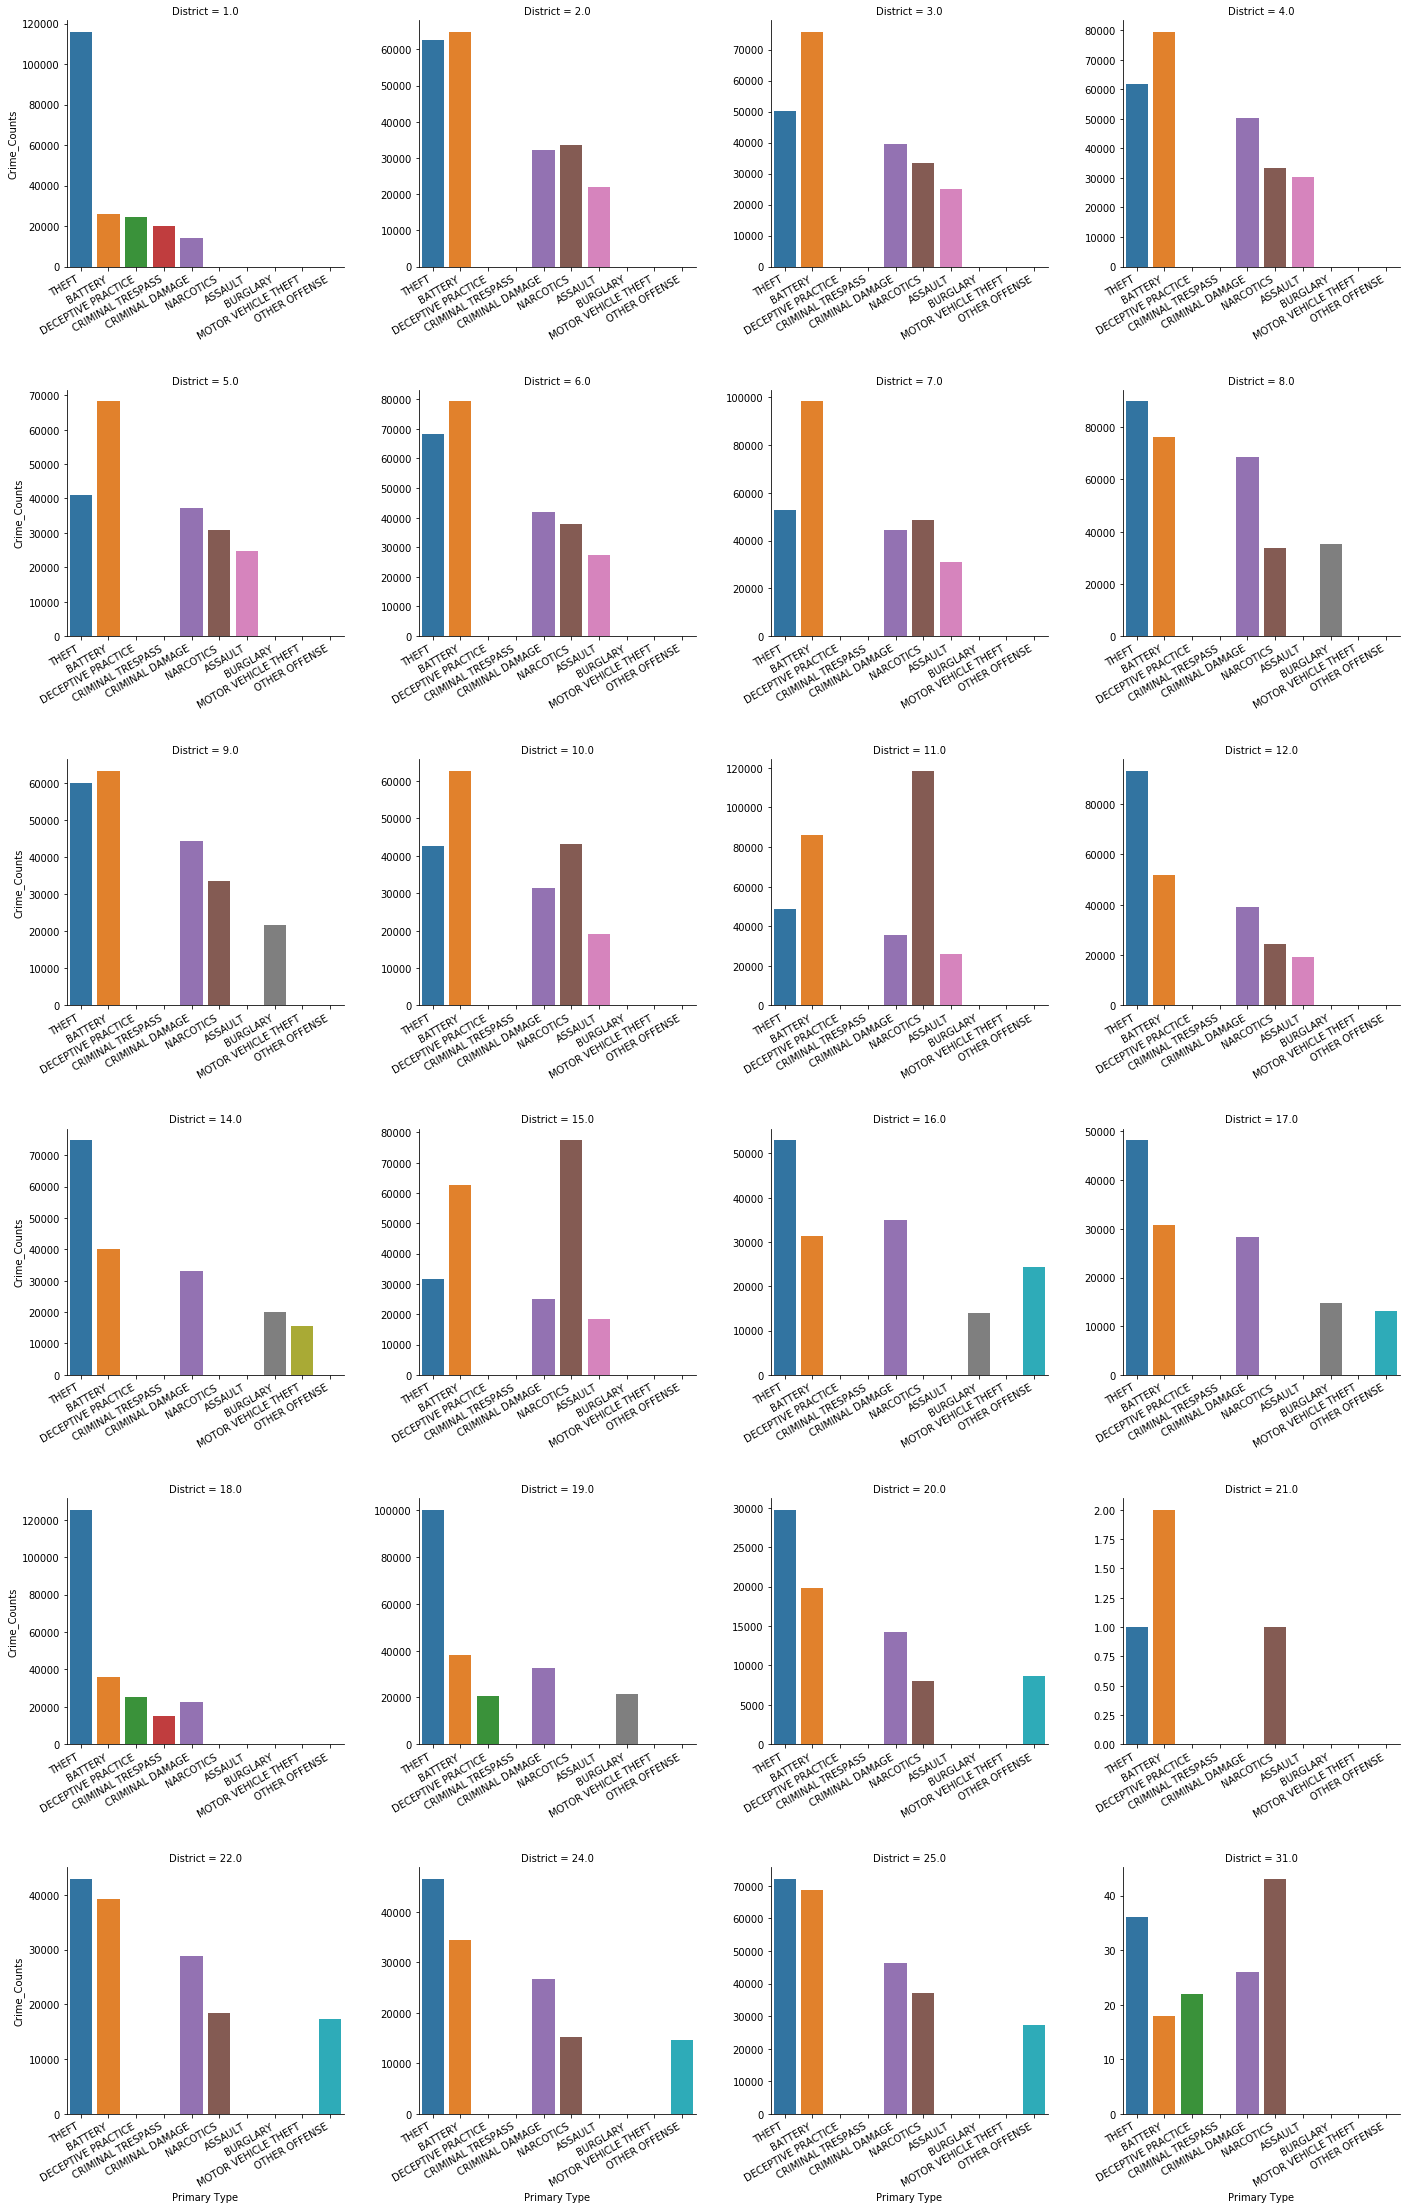

In [35]:
# Plotting top 5 crime types commited per District
crimeT_district = sns.catplot(x='Primary Type', y='Crime_Counts', col='District',
                              data=data, sharey=False, col_wrap=4, kind='bar')

# Setting visual aspects of FacetGrid
set_xticklabels(crimeT_district, 30)


In [ ]:
## Exploring the arrests per District. We can also take it as a measure of which are the most dangerous districts

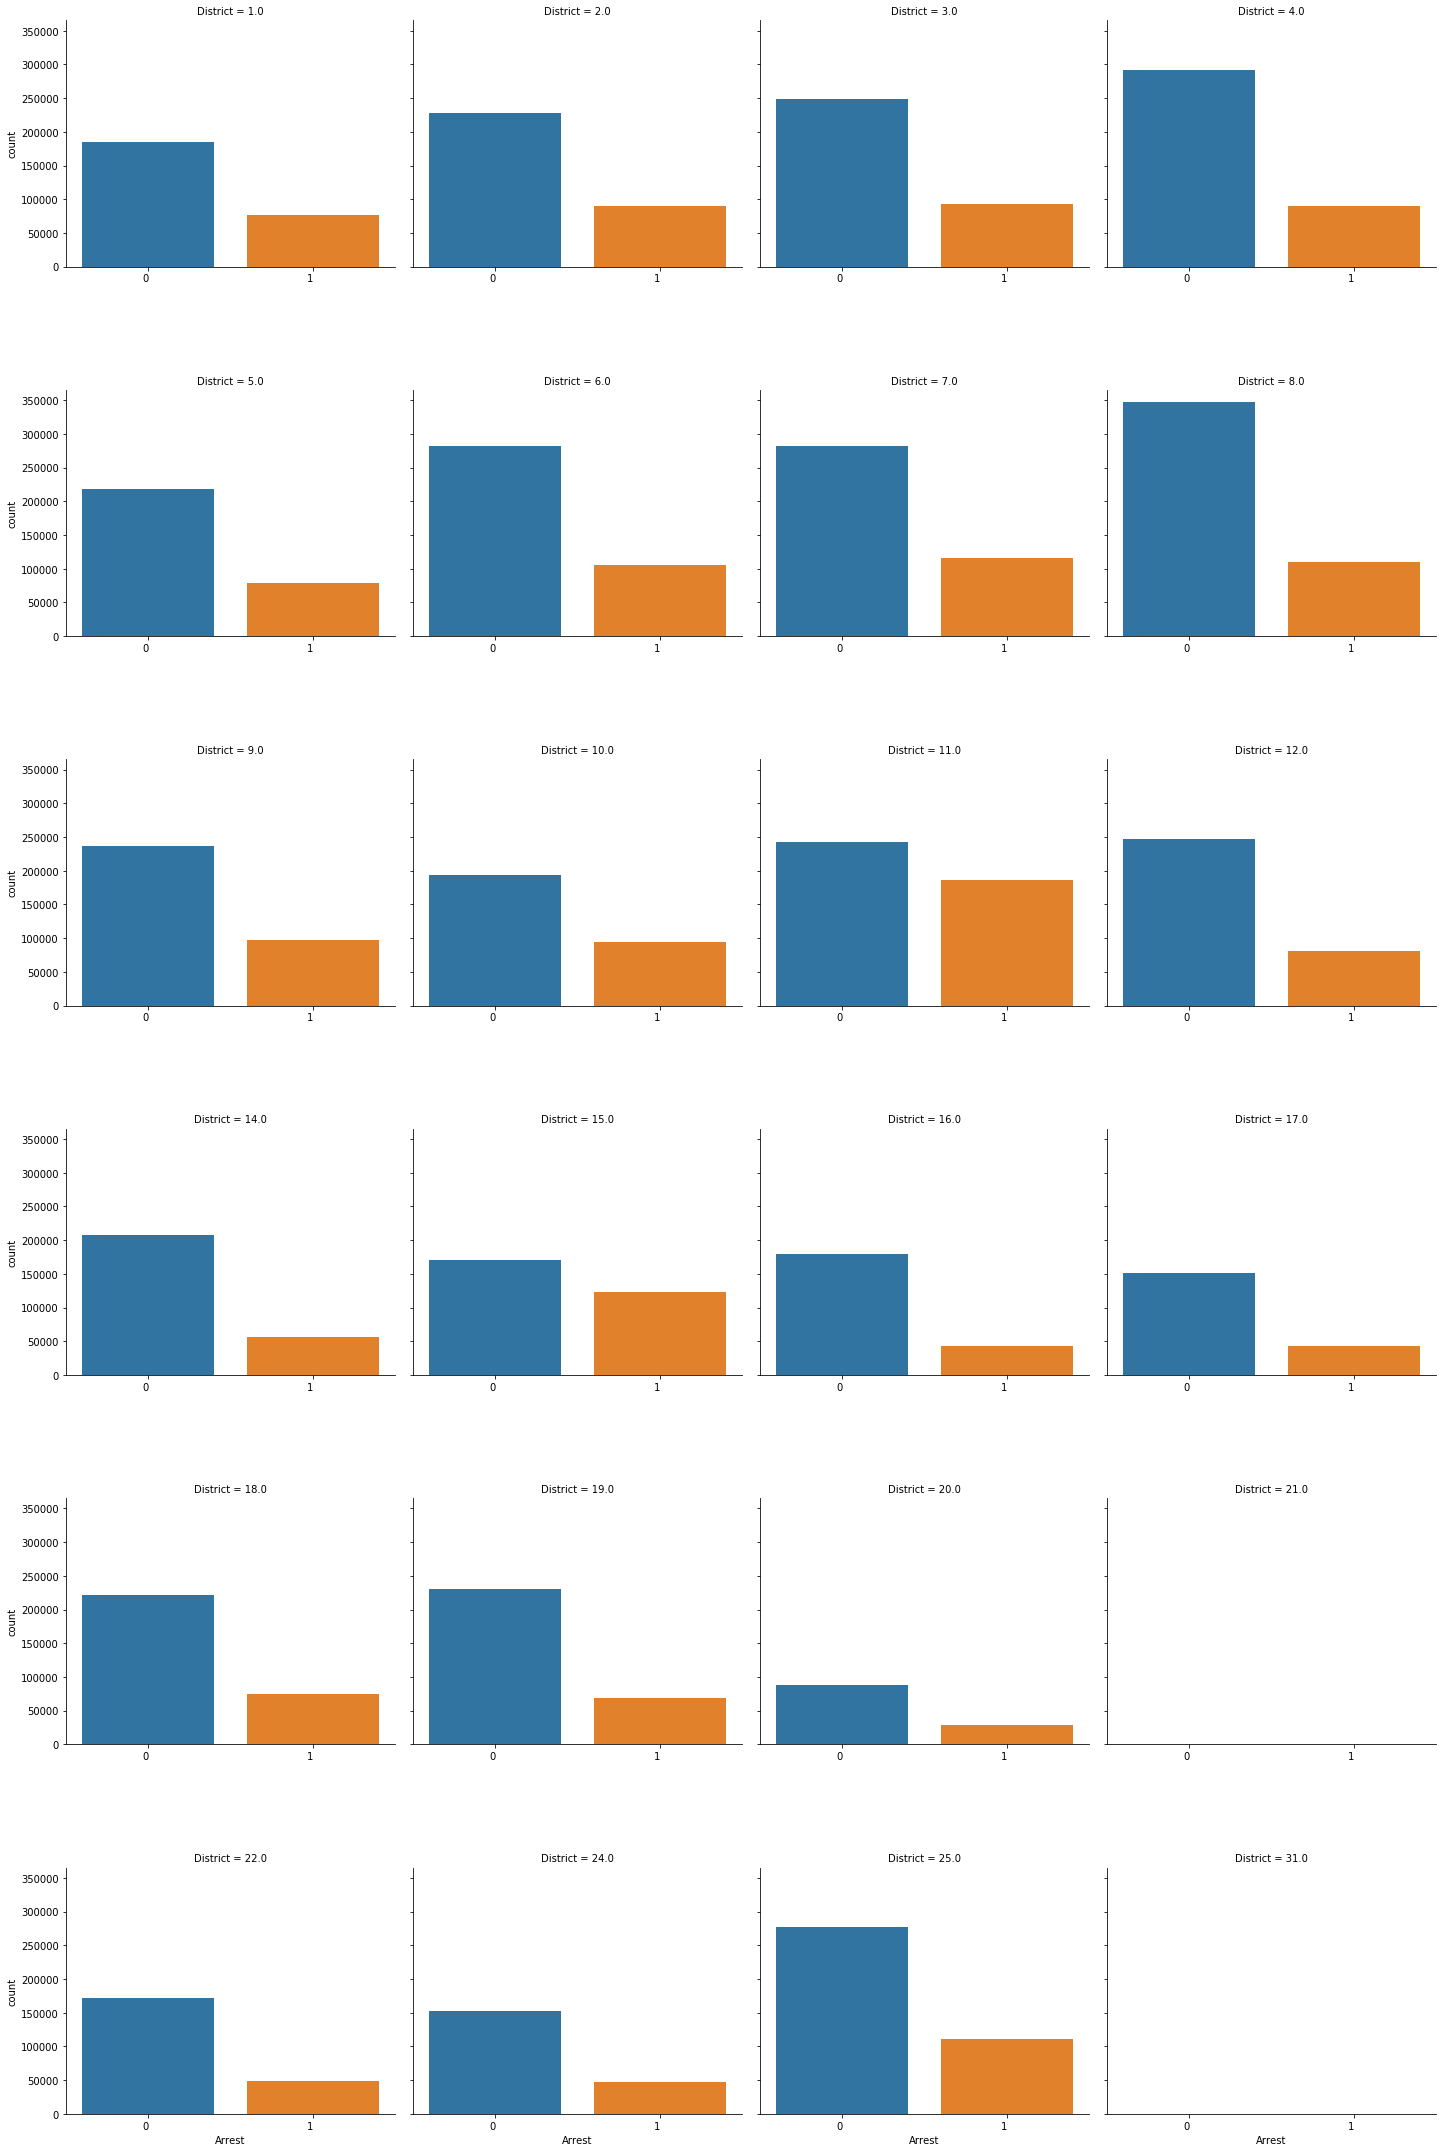

In [33]:
arrest_district = sns.catplot(x="Arrest", col="District", col_wrap=4, data=chicago_cmr1, kind="count")

# Setting visual aspects of FacetGrid
set_xticklabels(arrest_district)

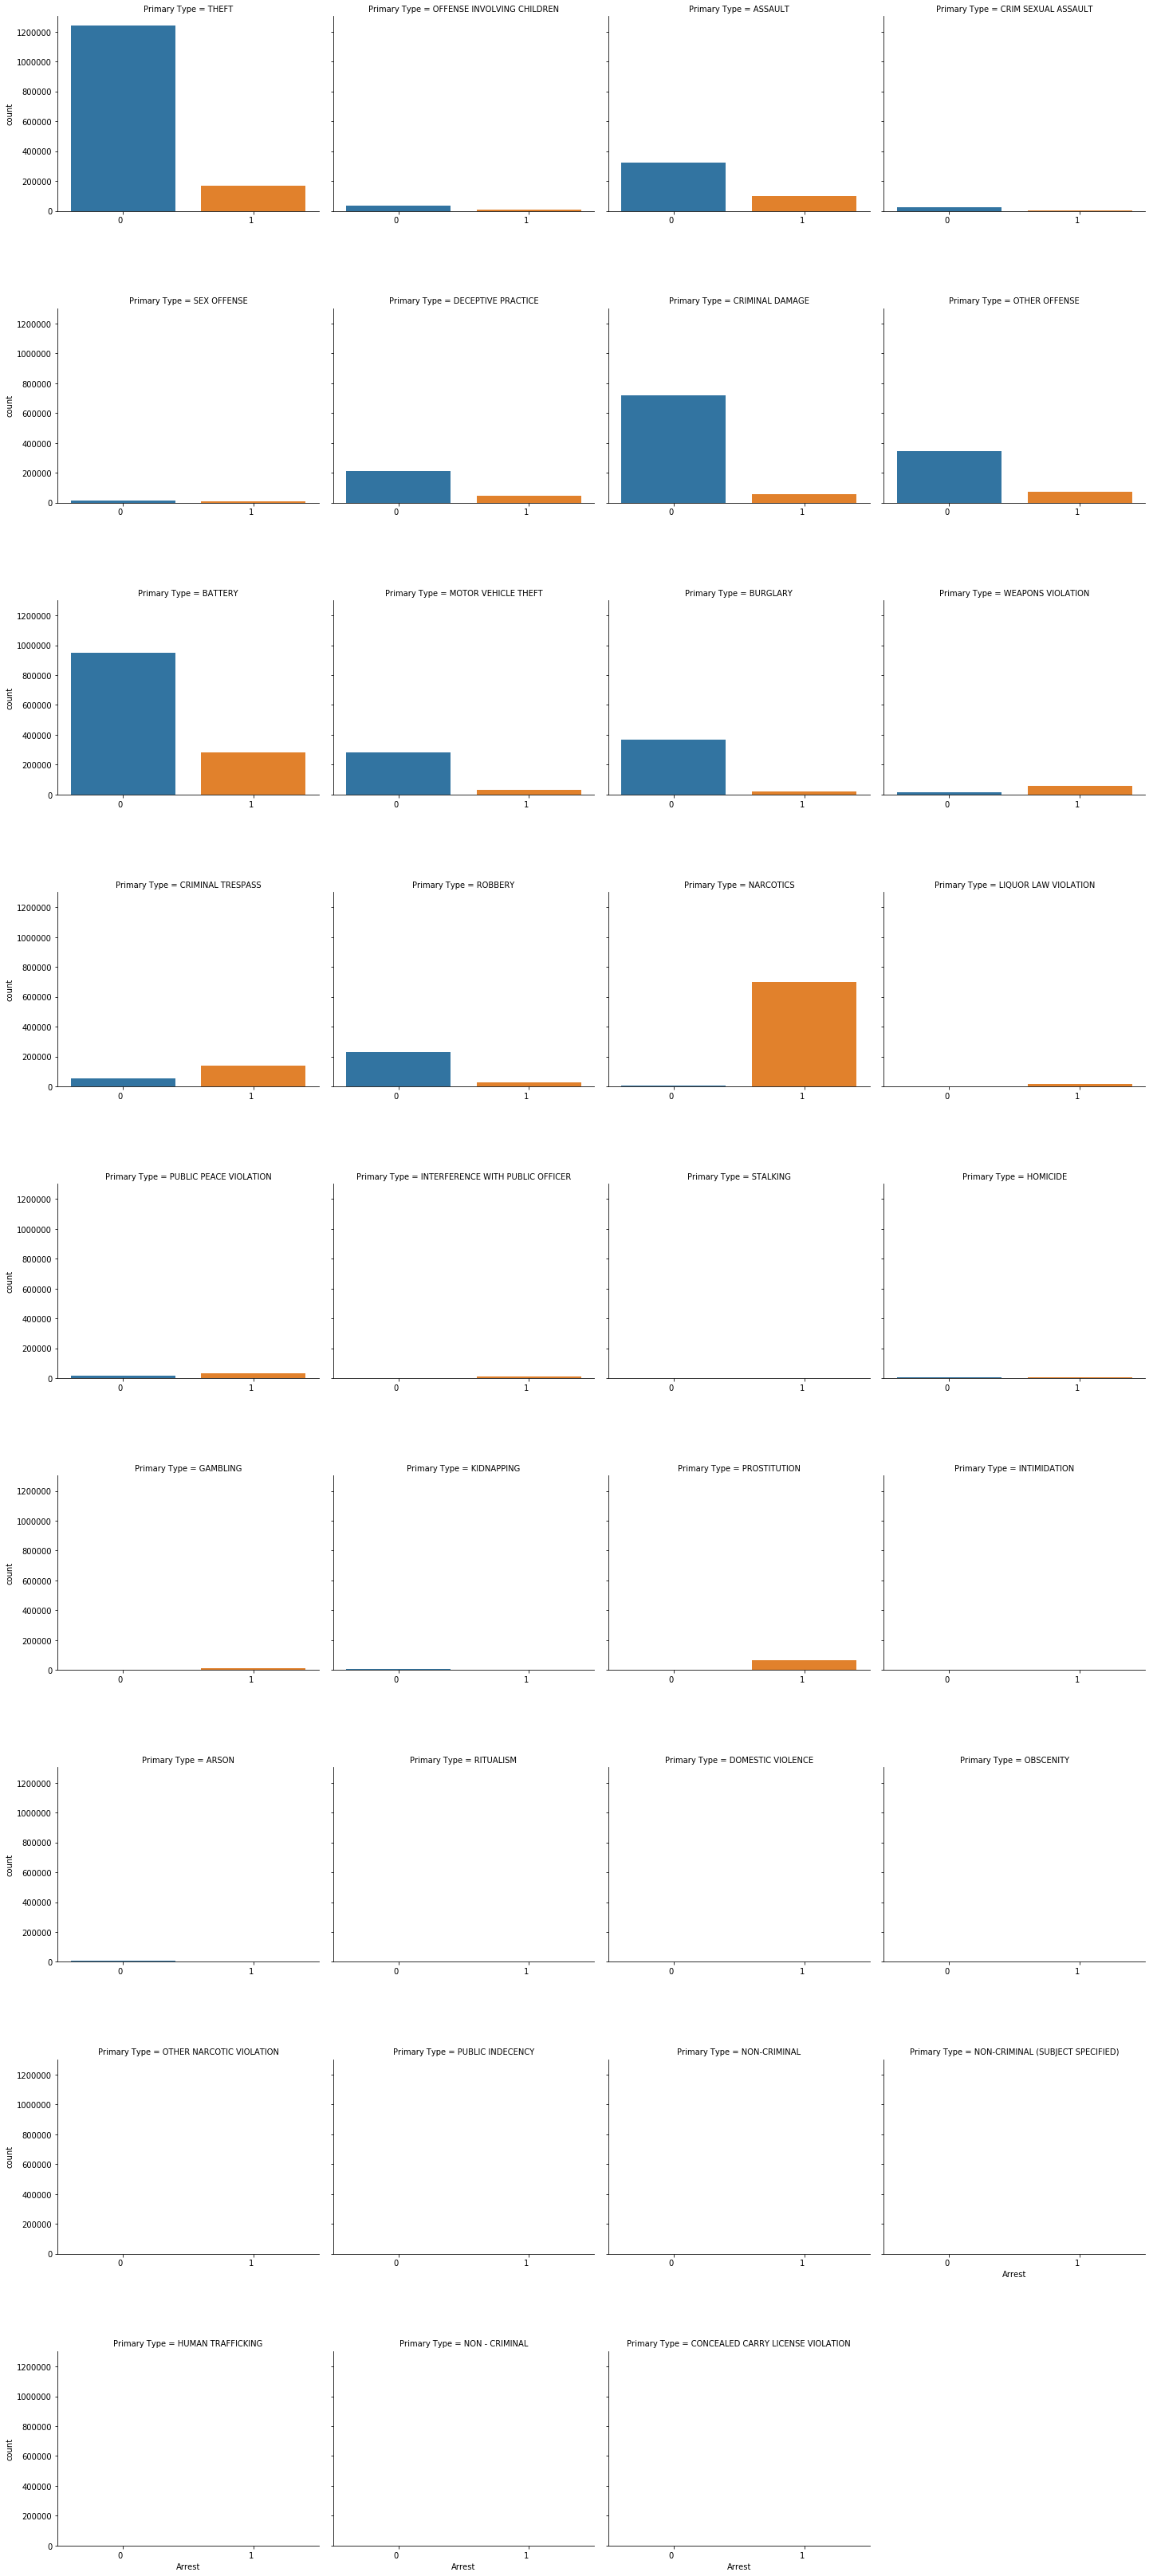

In [34]:
arrest_primaryT =sns.catplot(x="Arrest", col="Primary Type", col_wrap=4, data=chicago_cmr1, kind="count")

# Setting visual aspects of FacetGrid
set_xticklabels(arrest_primaryT)

In [87]:
chicago_cmr1.index = pd.DatetimeIndex(chicago_cmr1['Date'])

,Date,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Year,Latitude,Longitude,Location
Date,,,,,,,,,,,,,
2001-01-01 00:00:00,2001-01-01 00:00:00,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,0,0,631,6.0,2001,41.748623,-87.608654,"(41.748623027, -87.608654109)"
2001-01-01 00:00:00,2001-01-01 00:00:00,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,0,0,624,6.0,2001,41.754802,-87.598147,"(41.754802305, -87.598146873)"
2001-01-01 00:00:00,2001-01-01 00:00:00,0810,THEFT,OVER $500,APARTMENT,0,0,2332,19.0,2001,41.938952,-87.638164,"(41.938952432, -87.638163582)"
2001-01-01 00:00:00,2001-01-01 00:00:00,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,0,0,624,6.0,2001,41.752062,-87.607828,"(41.752061911, -87.607827503)"
2001-01-01 00:00:00,2001-01-01 00:00:00,1754,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,0,0,1013,10.0,2001,41.850386,-87.715108,"(41.850385805, -87.715107802)"
2001-01-01 00:00:00,2001-01-01 00:00:00,0810,THEFT,OVER $500,PARKING LOT/GARAGE(NON.RESID.),0,0,122,1.0,2001,41.886704,-87.628054,"(41.886703808, -87.628054456)"
2001-01-01 00:00:00,2001-01-01 00:00:00,0841,THEFT,FINANCIAL ID THEFT:$300 &UNDER,RESIDENCE,0,0,823,8.0,2001,41.780623,-87.707393,"(41.780622885, -87.707393268)"
2001-01-01 00:00:00,2001-01-01 00:00:00,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,0,0,1021,10.0,2001,41.862175,-87.711496,"(41.862174853, -87.711495725)"
2001-01-01 00:00:00,2001-01-01 00:00:00,0560,ASSAULT,SIMPLE,APARTMENT,0,1,2433,24.0,2001,41.994699,-87.657187,"(41.994699275, -87.657186625)"


In [101]:
crimes_per_district = chicago_cmr1.pivot_table(values='Date', aggfunc=np.size, columns='Primary Type', index=chicago_cmr1.index.date, fill_value=0)


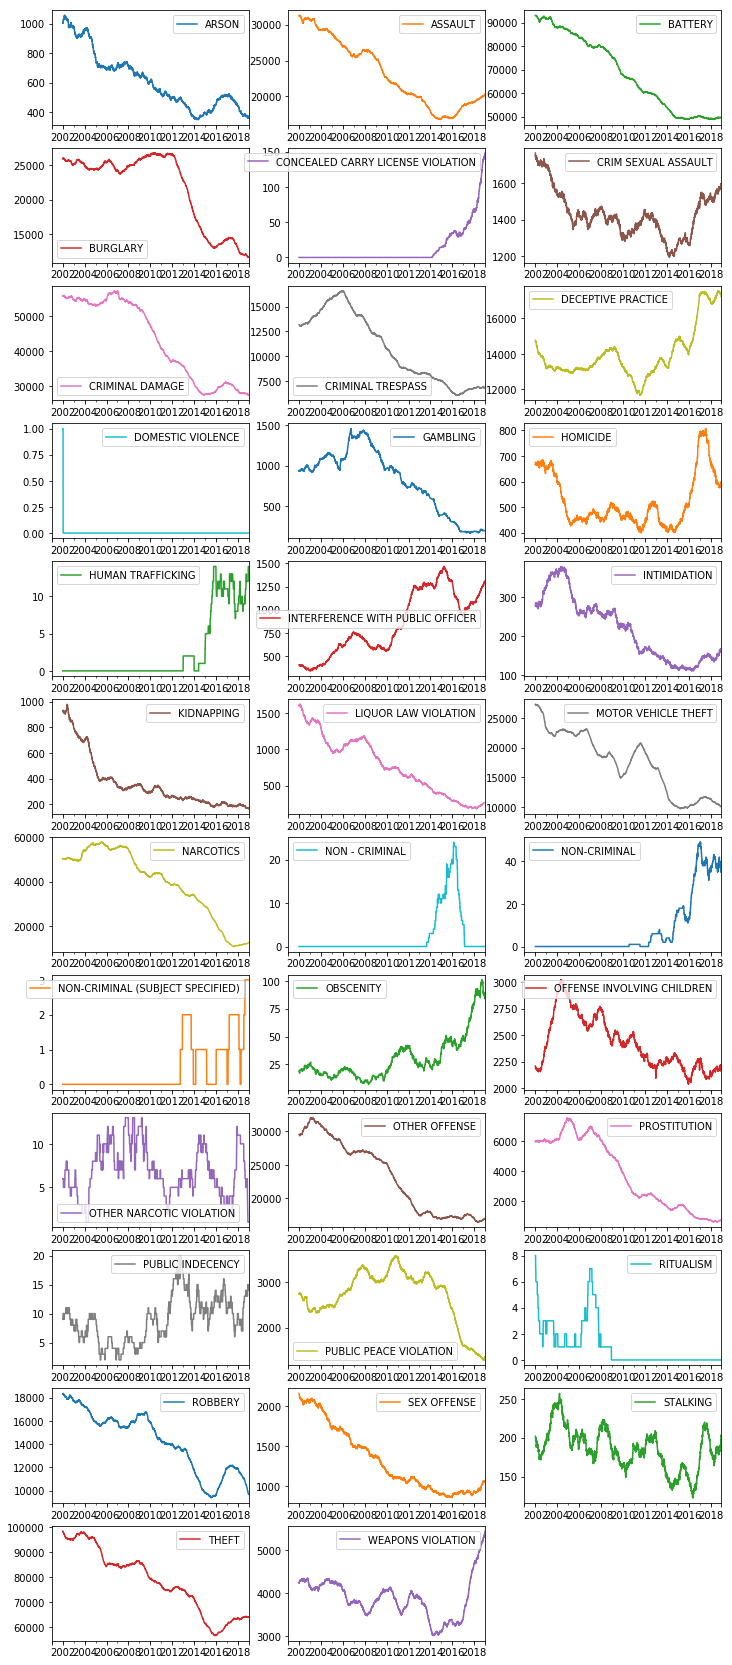

In [102]:
crimes_per_district.index = pd.DatetimeIndex(crimes_per_district.index)
plo = crimes_per_district.rolling(365).sum().plot(figsize=(12, 30), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

In [106]:
topk_loc_descr = chicago_cmr1.groupby(['Primary Type', 'Location Description']).size().reset_index(name='counts').groupby('Primary Type').apply(lambda x: x.sort_values('counts',ascending=False).head(3))

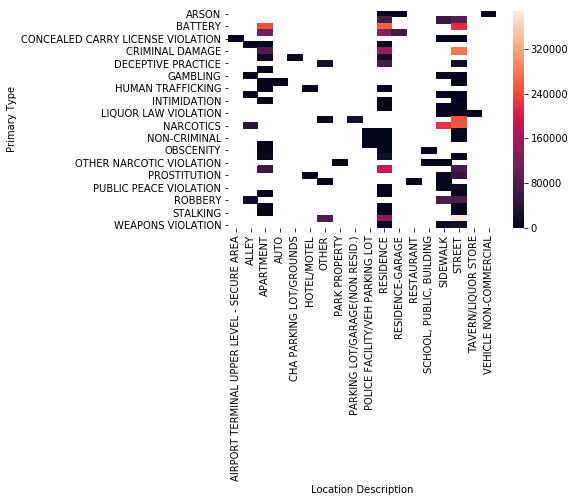

In [107]:
pivotdf = topk_loc_descr.pivot(index='Primary Type', columns='Location Description', values='counts')
sns.heatmap(pivotdf)

In [ ]:
chicago_cmr1